# Convert Bylot forcing files to CLASSIC
https://cccma.gitlab.io/classic/makeInputFiles.html

In [1]:
# Env: sc2_v0

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
import os

## Bylot Island, Canadian high Arctic

The site is a low-center polygon, with herb tundra and no erect vegetation

| Short name | byl |
|:-----------|:----|
| Location | 73.1504ºN, 80.0046ºW |
| Elevation | 25 m |
| Snow-free albedo | - |
| Simulation period | 11 July 2013 to 25 June 2019 |
| Temperature/humidity measurement height | 2.3 m |
| Wind measurement height | 2.3 m |
| Reference | Domine et al. ([2021](https://essd.copernicus.org/articles/13/4331/2021/)) |

In [157]:
site = 'byl'
site_longname = 'Bylot Island, Canadian high Arctic'

year_start = '2013'
year_end = '2019'

lat = 73.1504
lon = -80.0046

path = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_tmp = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/tmp'
path_out = '/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/'+site
path_out_CLASSIC = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site+'/forcing'

if os.path.exists(path_out):
    print(path_out+' already exist.')
else:
    os.makedirs(path_out)
    print(path_out+' has been created!')

if os.path.exists(path_out_CLASSIC):
    print(path_out_CLASSIC+' already exist.')
else:
    os.makedirs(path_out_CLASSIC)
    print(path_out_CLASSIC+' has been created!')

/home/lalandmi/Dropbox/data/SnowMIP/forcing/CLASSIC/byl already exist.
/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/byl/forcing already exist.


### Open original forcing file

In [3]:
ds = xr.open_dataset(path+'/met_insitu_'+site+'_'+year_start+'_'+year_end+'.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 52202)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-11T09:00:00 ... 2019-06-25T10:00:00
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...

In [4]:
ds.time.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot/met_insitu_byl_2013_2019.nc',
 'original_shape': (52202,),
 'dtype': dtype('int64'),
 'units': 'hours since 2013-07-11 09:00:00',
 'calendar': 'proleptic_gregorian'}

In [5]:
# Check if there are leap years
ds.sel(time='2016-02')

<xarray.Dataset>
Dimensions:  (time: 696)
Coordinates:
  * time     (time) datetime64[ns] 2016-02-01 ... 2016-02-29T23:00:00
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...

### Resample to 30 minute time step for CLASSIC
Otherwise CLASSIC interpolates the forcing by itself and makes some assumptions more adapted for 6h forcing files
(e.g., for the SWdown that will lose the peaks)

In [6]:
ds_30min = ds.resample(time='30min').interpolate()
ds_30min

<xarray.Dataset>
Dimensions:  (time: 104403)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-11T09:00:00 ... 2019-06-25T10:00:00
Data variables:
    Wind     (time) float64 1.53 1.468 1.405 1.713 ... 1.757 1.45 1.292 1.135
    Tair     (time) float64 6.82 6.889 6.958 7.941 ... 10.59 10.43 9.809 9.186
    Qair     (time) float64 0.005626 0.005593 0.005559 ... 0.004688 0.004424
    LWdown   (time) float64 308.9 304.3 299.7 294.6 ... 252.7 253.9 255.9 257.9
    SWdown   (time) float64 250.9 280.7 310.5 491.6 ... 548.8 580.8 629.9 679.0
    Psurf    (time) float64 1.002e+05 1.002e+05 ... 1.015e+05 1.015e+05
    Rainf    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Snowf    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

### Extend beginning and the end of the forcing
Because CLASSIC only accept full years (will need to be removed for analyses)

In [10]:
time_ext = pd.date_range(
    pd.to_datetime(ds_30min.time.dt.year[0], format='%Y'), 
    str(ds_30min.time.dt.year[-1].values.item(0))+'-12-31 23:30:00',
    freq='30min'
)
time_ext

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 00:30:00',
               '2013-01-01 01:00:00', '2013-01-01 01:30:00',
               '2013-01-01 02:00:00', '2013-01-01 02:30:00',
               '2013-01-01 03:00:00', '2013-01-01 03:30:00',
               '2013-01-01 04:00:00', '2013-01-01 04:30:00',
               ...
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00',
               '2019-12-31 23:00:00', '2019-12-31 23:30:00'],
              dtype='datetime64[ns]', length=122688, freq='30T')

In [15]:
ds_30min_ext = ds_30min.reindex(time=time_ext)
ds_30min_ext

<xarray.Dataset>
Dimensions:  (time: 122688)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2019-12-31T23:30:00
Data variables:
    Wind     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Tair     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Qair     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    LWdown   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    SWdown   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Psurf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Rainf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Snowf    (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [69]:
# ds_30min    : XXXXXXXXXXXXXXXXXXXXXXXXXXXX........... i_start_next_year ....... i_end_next_year
# ds_30min_ext: 1rst jan .... i_before_start

i_before_start = ds_30min_ext.sel(time=slice(None,ds_30min.time[0])).time.size - 1 
i_start_next_year = ds_30min.sel(time=slice(None, year_start)).time.size
i_end_next_year = i_start_next_year + i_before_start

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][:i_before_start].size,
    ds_30min['Wind'][i_start_next_year:i_end_next_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][:i_before_start] = ds_30min[key][i_start_next_year:i_end_next_year].values

In [100]:
# ds_30min    : i_start_prev_year ....... i_end_prev_year.......XXXXXXXXXXXXXXXXXXXXXXXXXXXX
# ds_30min_ext: ............................................... i_after_end.......... 31 dec

i_after_end = ds_30min_ext.sel(time=slice(ds_30min.time[-1]+1, None)).time.size
i_end_prev_year = ds_30min.time.sel(time=slice(year_end, None)).time.size
i_start_prev_year = i_end_prev_year + i_after_end

# Check the dimensions are right before replacement
np.testing.assert_equal(
    ds_30min_ext['Wind'][-i_after_end:].size,
    ds_30min['Wind'][-i_start_prev_year:-i_end_prev_year].size
)

for key in list(ds.keys()):
    ds_30min_ext[key][-i_after_end:] = ds_30min[key][-i_start_prev_year:-i_end_prev_year].values

Text(0.5, 0.98, 'Bylot Island, Canadian high Arctic')

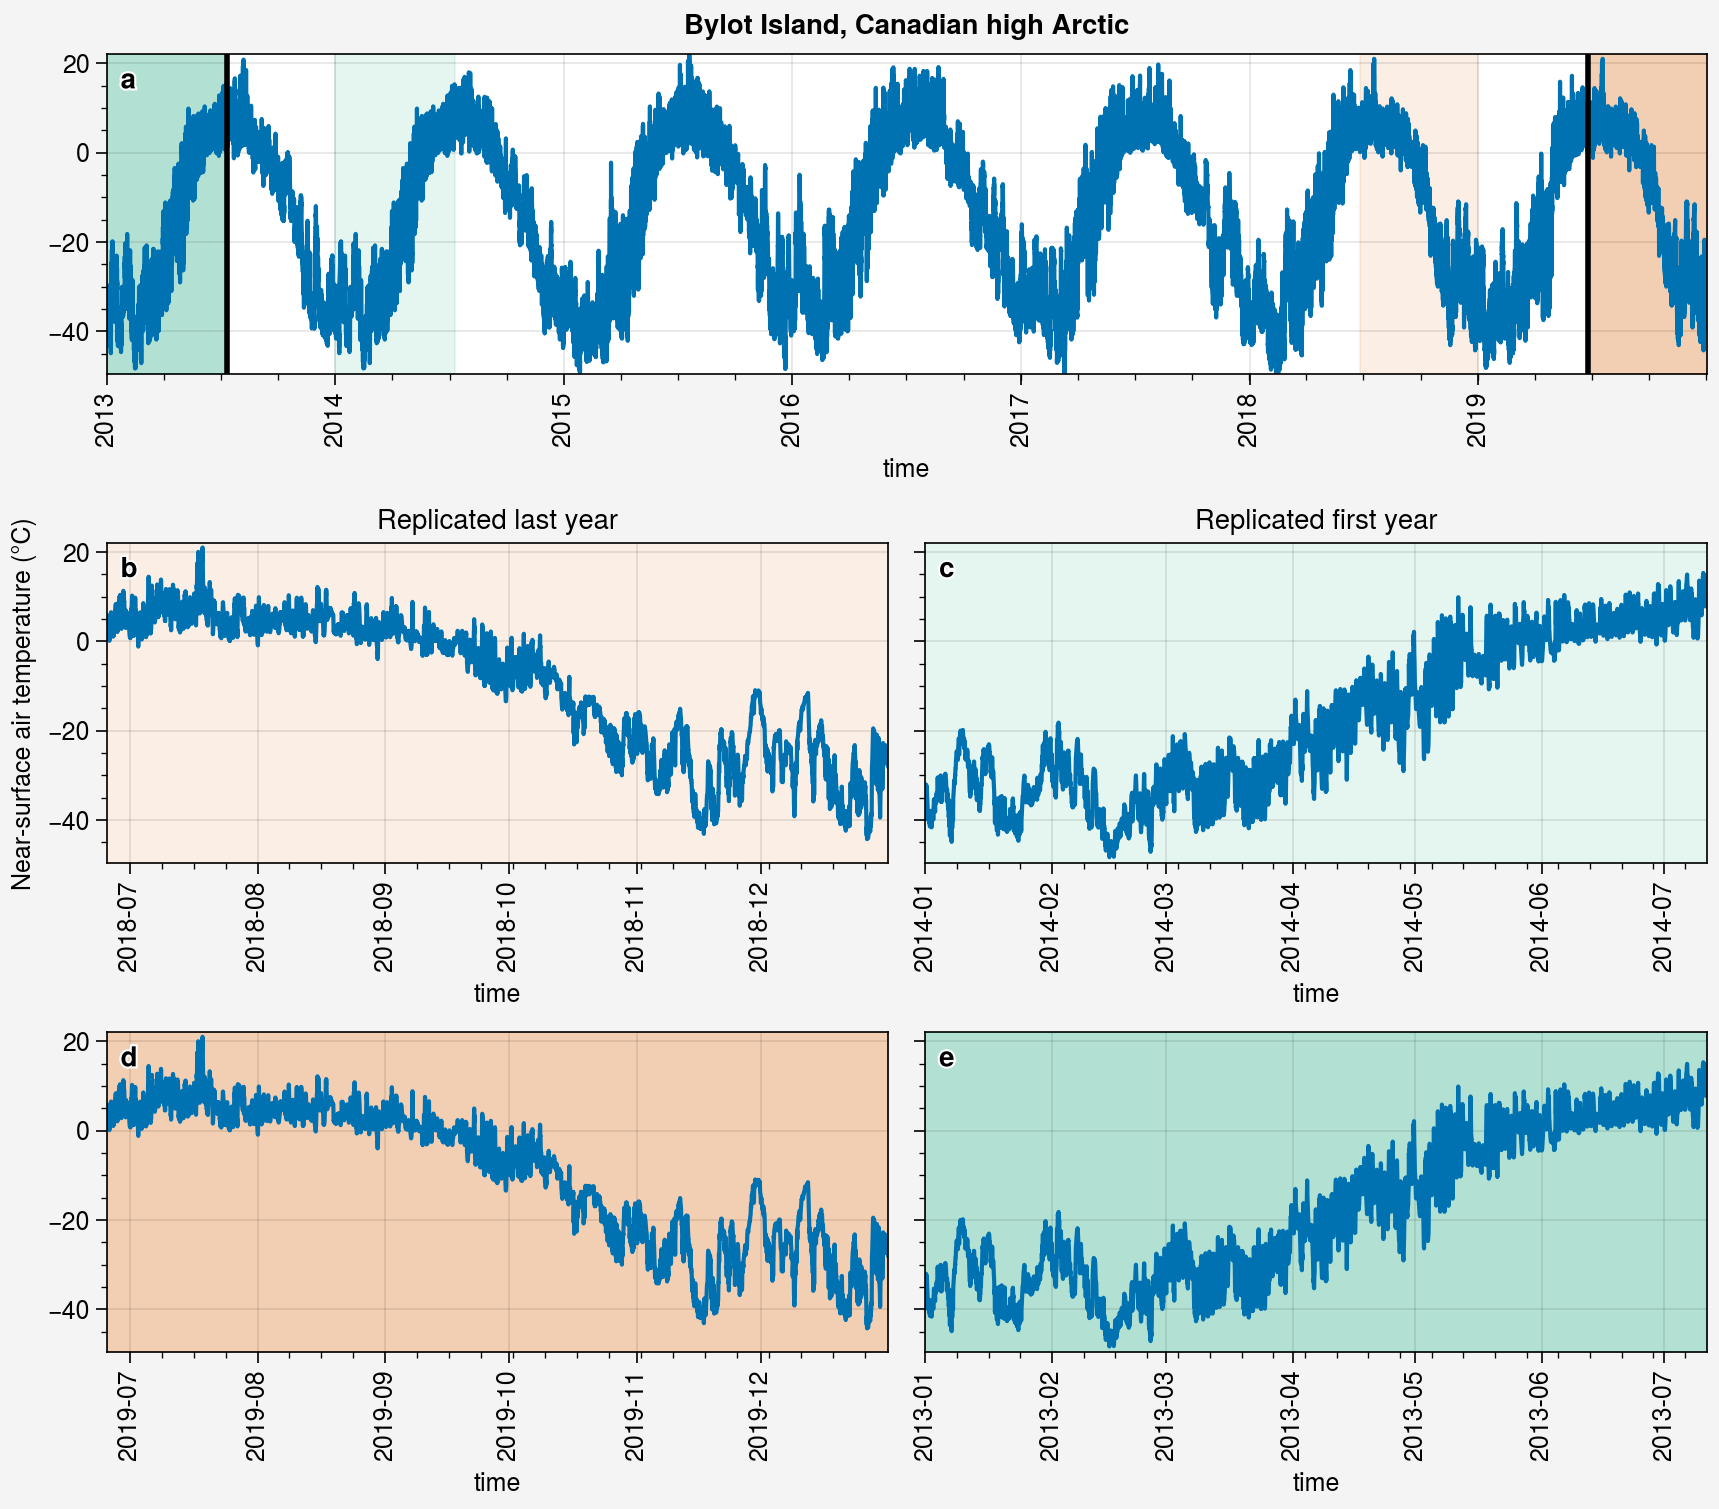

In [188]:
%matplotlib inline
fig, axs = pplt.subplots([[1, 1], [2, 3], [4, 5]], refaspect=5, refwidth=8, sharex=0)

key = 'Tair'

axs[0].plot(ds_30min_ext[key])

axs[0].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[0].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)

axs[0].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs[0].axvline(ds_30min[key][0].time.values, lw=2, ls='-', color='k')
axs[0].axvline(ds_30min[key][-1].time.values, lw=2, ls='-', color='k')

axs[2].format(title='Replicated first year')
axs[4].plot(ds_30min_ext[key][:i_before_start])
axs[4].fill_between(
    [ds_30min_ext[key][0].time.values, ds_30min_ext[key][i_before_start].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.3
)
axs[2].plot(ds_30min[key][i_start_next_year:i_end_next_year])
axs[2].fill_between(
    [ds_30min[key][i_start_next_year].time.values, ds_30min[key][i_end_next_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C2', alpha=0.1
)

axs[1].format(title='Replicated last year')
axs[3].plot(ds_30min_ext[key][-i_after_end:])
axs[3].fill_between(
    [ds_30min_ext[key][-i_after_end].time.values, ds_30min_ext[key][-1].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.3
)
axs[1].plot(ds_30min[key][-i_start_prev_year:-i_end_prev_year])
axs[1].fill_between(
    [ds_30min[key][-i_start_prev_year].time.values, ds_30min[key][-i_end_prev_year].time.values], 
    ds_30min_ext[key].min(), ds_30min_ext[key].max(), color='C1', alpha=0.1
)

axs.format(abc=True, abcloc='ul')
fig.suptitle(site_longname)


### Convert time from relative to absolute
https://sourceforge.net/p/nco/discussion/9830/thread/175b4c98e1/?limit=25

The time format `day as %Y%m%d.%f` is <mark>**required** by CLASSIC</mark>

Note: you need CDO installed to run the next cell (`!` allow to run bash command in the notebook)

In [190]:
ds_30min_ext.to_netcdf(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'.nc')

In [191]:
!cdo -a -f nc copy {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}.nc {path_tmp}/met_insitu_{site}_30min_ext_{year_start}_{year_end}_a.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 981504 values from 8 variables over 122688 timesteps [10.43s 2264MB]


## Open the new file with absolute time

In [192]:
ds = xr.open_dataset(path_tmp+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_a.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 122688)
Coordinates:
  * time     (time) float64 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Data variables:
    Wind     (time) float64 ...
    Tair     (time) float64 ...
    Qair     (time) float64 ...
    LWdown   (time) float64 ...
    SWdown   (time) float64 ...
    Psurf    (time) float64 ...
    Rainf    (time) float64 ...
    Snowf    (time) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 12 16:27:16 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [193]:
ds.time

<xarray.DataArray 'time' (time: 122688)>
array([20130101.      , 20130101.020833, 20130101.041667, ..., 20191231.9375  ,
       20191231.958333, 20191231.979167])
Coordinates:
  * time     (time) float64 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
Attributes:
    standard_name:  time
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T

### Add the lat/lon dimensions of the site (<mark>required by CLASSIC</mark>)

Note: the values of the coordinates does not seem to matter for CLASSIC (the attributes neither)

In [194]:
ds = ds.assign_coords(lon=lon)
ds = ds.expand_dims('lon')
ds['lon'] = ds.lon.assign_attrs(
    standard_name='Longitude',
    units='degrees_east',
    axis='X'
)

ds = ds.assign_coords(lat=lat)
ds = ds.expand_dims('lat')
ds['lat'] = ds.lat.assign_attrs(
    standard_name='Latitude',
    units='degrees_north',
    axis='Y'
)

# Transpose the dimension to put the time first (as required by CLASSIC)
ds = ds.transpose('time', 'lat', 'lon')

ds

<xarray.Dataset>
Dimensions:  (time: 122688, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon      (lon) float64 -80.0
  * lat      (lat) float64 73.15
Data variables:
    Wind     (time, lat, lon) float64 0.134 0.105 0.076 ... 1.0 0.369 0.271
    Tair     (time, lat, lon) float64 -39.72 -39.49 -39.27 ... -28.13 -28.01
    Qair     (time, lat, lon) float64 7.51e-05 7.665e-05 ... 0.0002744 0.000275
    LWdown   (time, lat, lon) float64 162.2 162.3 162.3 ... 181.4 170.2 166.9
    SWdown   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Psurf    (time, lat, lon) float64 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf    (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 12 16:27:16 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

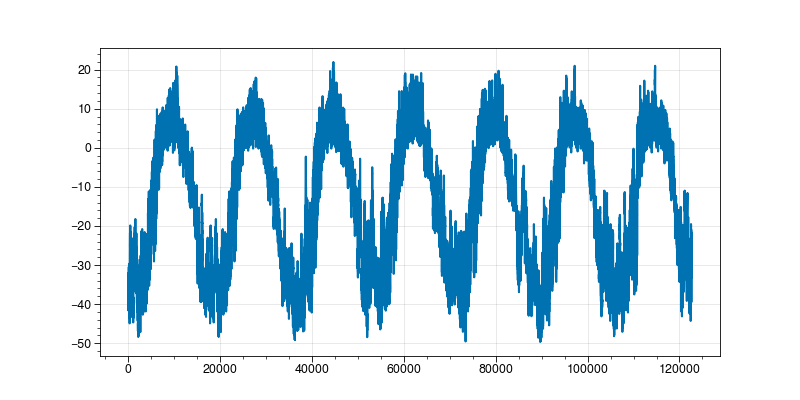

In [195]:
%matplotlib widget
plt.figure(figsize=(8,4))
plt.plot(ds.Tair.squeeze().values)

### Add Rainf and Snowf (<mark>required by CLASSIC</mark>)

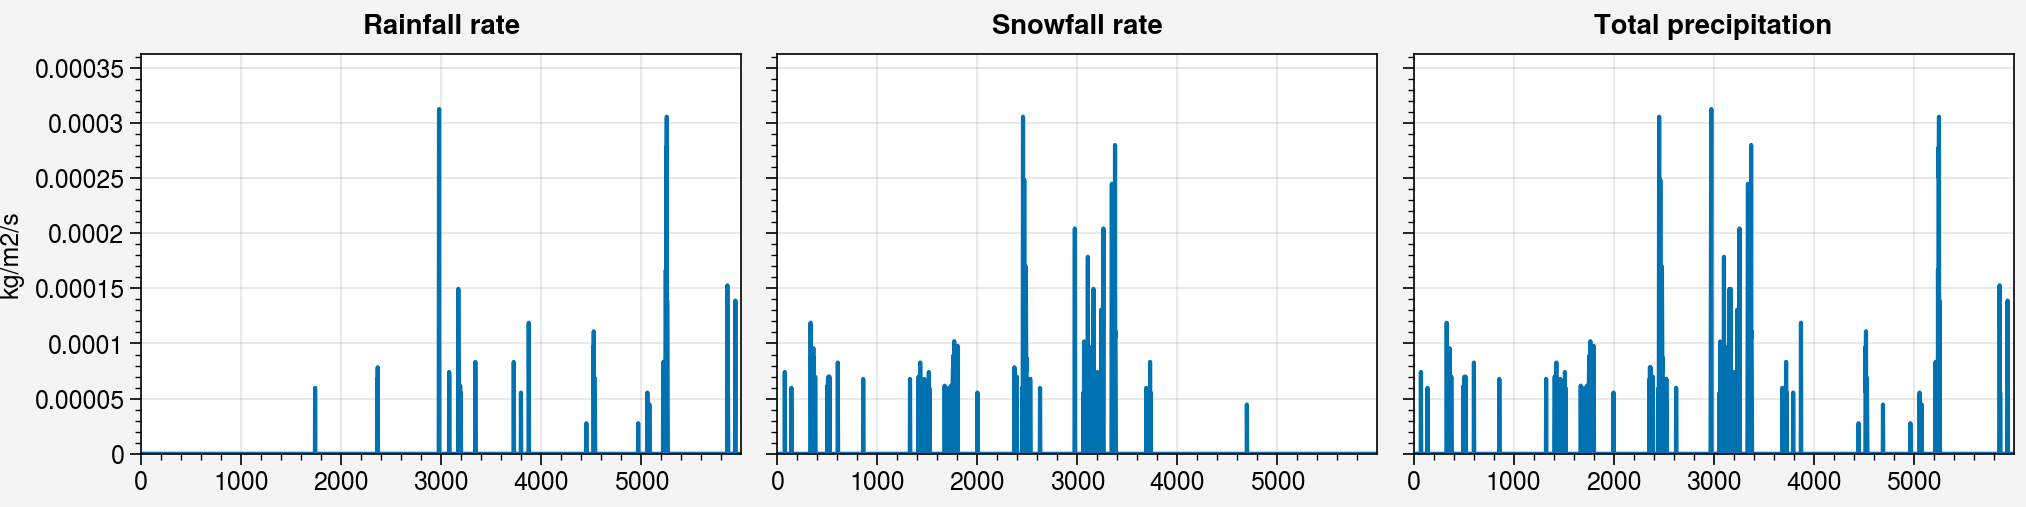

In [199]:
%matplotlib inline
fig, axs = pplt.subplots(ncols=3, nrows=1, refaspect=1.5, refwidth=3)

i_start = 2000*2
i_end = 5000*2

axs[0].plot(ds.Rainf.squeeze().values[i_start:i_end])
axs[1].plot(ds.Snowf.squeeze().values[i_start:i_end])
axs[2].plot(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end])

for ax in axs:
    ax.format(
        ylabel=ds.Rainf.attrs['units'], 
        ylim=(0,max(ds.Rainf.squeeze().values[i_start:i_end] + ds.Snowf.squeeze().values[i_start:i_end]).item(0) + 0.00005)
    )
    
axs.format(
    collabels=[ds.Rainf.attrs['long_name'], ds.Snowf.attrs['long_name'], 'Total precipitation']
)


In [200]:
ds['TotPrecip'] = ds.Rainf + ds.Snowf
ds.TotPrecip.attrs['long_name'] = 'Total precipitaion rate (Rainf + Snowf)'
ds.TotPrecip.attrs['units'] = ds.Rainf.attrs['units']
ds

<xarray.Dataset>
Dimensions:    (time: 122688, lat: 1, lon: 1)
Coordinates:
  * time       (time) float64 2.013e+07 2.013e+07 ... 2.019e+07 2.019e+07
  * lon        (lon) float64 -80.0
  * lat        (lat) float64 73.15
Data variables:
    Wind       (time, lat, lon) float64 0.134 0.105 0.076 ... 1.0 0.369 0.271
    Tair       (time, lat, lon) float64 -39.72 -39.49 -39.27 ... -28.13 -28.01
    Qair       (time, lat, lon) float64 7.51e-05 7.665e-05 ... 0.000275
    LWdown     (time, lat, lon) float64 162.2 162.3 162.3 ... 181.4 170.2 166.9
    SWdown     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Psurf      (time, lat, lon) float64 1.012e+05 1.012e+05 ... 1.011e+05
    Rainf      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Snowf      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TotPrecip  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Feb 12 16:27:16 2024: cdo -a -f nc copy /home/lalandmi/...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

## Save forcing files

CLASSIC **requires** <mark>one file per forcing variable</mark>

Note: I save the files directly to CLASSIC folder and here to keep more flexibility in the future

In [201]:
for key in list(ds.keys()):
    ds[key].to_netcdf(path_out+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')
    ds[key].to_netcdf(path_out_CLASSIC+'/met_insitu_'+site+'_30min_ext_'+year_start+'_'+year_end+'_'+key+'.nc')

In [202]:
!ls {path_out}

met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
met_insitu_byl_2014_2018_SWdown.nc
met_insitu_byl_2014_2018_Tair.nc
met_insitu_byl_2014_2018_TotPrecip.nc
met_insitu_byl_2014_2018_Wind.nc
met_insitu_byl_30min_2014_2018_LWdown.nc
met_insitu_byl_30min_2014_2018_Psurf.nc
met_insitu_byl_30min_2014_2018_Qair.nc
met_insitu_byl_30min_2014_2018_Rainf.nc
met_insitu_byl_30min_2014_2018_Snowf.nc
met_insitu_byl_30min_2014_2018_SWdown.nc
met_insitu_byl_30min_2014_2018_Tair.nc
met_insitu_byl_30min_2014_2018_TotPreci

In [203]:
!ls {path_out_CLASSIC}

met_insitu_byl_1.3SWd_2014_2018_LWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Psurf.nc
met_insitu_byl_1.3SWd_2014_2018_Qair.nc
met_insitu_byl_1.3SWd_2014_2018_Rainf.nc
met_insitu_byl_1.3SWd_2014_2018_Snowf.nc
met_insitu_byl_1.3SWd_2014_2018_SWdown.nc
met_insitu_byl_1.3SWd_2014_2018_Tair.nc
met_insitu_byl_1.3SWd_2014_2018_TotPrecip.nc
met_insitu_byl_1.3SWd_2014_2018_Wind.nc
met_insitu_byl_2014_2018_LWdown.nc
met_insitu_byl_2014_2018_Psurf.nc
met_insitu_byl_2014_2018_Qair.nc
met_insitu_byl_2014_2018_Rainf.nc
met_insitu_byl_2014_2018_Snowf.nc
met_insitu_byl_2014_2018_SWdown.nc
met_insitu_byl_2014_2018_Tair.nc
met_insitu_byl_2014_2018_TotPrecip.nc
met_insitu_byl_2014_2018_Wind.nc
met_insitu_byl_30min_2014_2018_LWdown.nc
met_insitu_byl_30min_2014_2018_Psurf.nc
met_insitu_byl_30min_2014_2018_Qair.nc
met_insitu_byl_30min_2014_2018_Rainf.nc
met_insitu_byl_30min_2014_2018_Snowf.nc
met_insitu_byl_30min_2014_2018_SWdown.nc
met_insitu_byl_30min_2014_2018_Tair.nc
met_insitu_byl_30min_2014_2018_TotPreci

### Keep the same initial files from Ref run (but redo spinup)

In [208]:
# path_init = '/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/'+site
# exp2 = 'peat_30min_ext'
# # exp2 = 'Ref_30min_ext'
# !cp {path_init}/{site}_init_spinup_Ref.nc {path_init}/{site}_init_spinup_{exp2}.nc
# !cp {path_init}/rsfile_spinup_Ref.nc {path_init}/rsfile_spinup_{exp2}.nc

In [209]:
!mkdir /home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/{site}/spinup_{exp2}